# Progetto di Data and Web mining

Matteo Spanio, A.A. 2021/2022

# Linear model

Let's verifity the assumption of linearity relation

## Globally

Import data

In [1]:
import Zillow.data as zd
from Zillow.transform import ZillowTransformer, ZillowEncoder
import warnings
warnings.filterwarnings("ignore")

df_train = zd.get_train_dataset()
df_validation = zd.get_validation_dataset()

preprocessor = ZillowTransformer()
preprocessor.fit(df_train)

df_train = preprocessor.transform(df_train)
df_validation = preprocessor.transform(df_validation)

# one hot encoding and column type transform
encoder = ZillowEncoder()
encoder.fit(df_train)

df_train = encoder.transform(df_train)
df_validation = encoder.transform(df_validation)

In [2]:
X_train, y_train = zd.split_x_y(df_train)
X_test, y_test = zd.split_x_y(df_validation)

The linear regression model implemented by sklearn provides two parameters to set, usually it isn't a model to tune, but since there are these parameters and linear regression training is really fast is worth looking for the best params.

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from Zillow.metrics import print_measure
import pandas as pd

lr = LinearRegression()

params = {
    'fit_intercept': [True, False],
    'positive': [False, True]
}

gscv = GridSearchCV(estimator=lr,
                    scoring='neg_mean_absolute_error',
                    param_grid=params,
                    cv=5,
                    n_jobs=-1
                   )

gscv.fit(X_train, y_train)

gscv.best_params_

{'fit_intercept': False, 'positive': True}

In [4]:
print_measure(y_true=y_test, y_pred=gscv.predict(X_test))

Mean absolute error: 0.07094
 Mean squared error: 0.02999
           R2 score: 0.00212


<div class='alert alert-info'>
    From now on I'll assume that <code>fit_intercept = False</code> and <code>positive = True</code> are the best parameters for any linear regression model on this dataset
</div>

Then it's interesting to look if we can optimize this model, maybe not all features are useful. Let's get a feature ranking with recursive feature elimination

In [8]:
from sklearn.feature_selection import RFE

lm = LinearRegression(fit_intercept=False, positive=True)
rfe = RFE(estimator=lm, n_features_to_select=1)

rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(fit_intercept=False, positive=True),
    n_features_to_select=1)

In [9]:
from sklearn.model_selection import cross_val_score
import numpy as np

best_features = np.array(X_train.columns.to_list())[ np.argsort(rfe.ranking_)[::-1] ]

mae = []

for f in range(1,len(best_features)+1):
    lm = LinearRegression(fit_intercept=False, positive=True)
    scores = cross_val_score(lm, 
                             X_train.loc[:,best_features[:f]], y_train, 
                             cv=5, scoring='neg_mean_absolute_error')
    mae += [-scores.mean()]

Full score: 0.06864720698038897
Best score: 0.06851185330503948


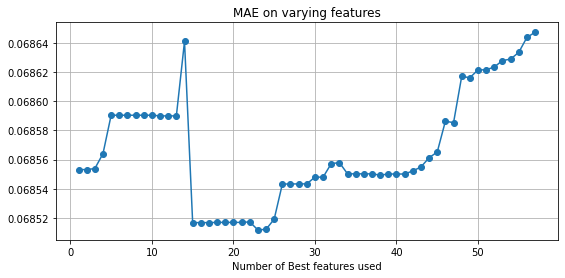

In [10]:
import matplotlib.pyplot as plt

print ("Full score:", mae[-1])
print ("Best score:", min(mae))

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(range(1,len(best_features)+1), mae, 'o-', label="MAE")
ax.set_title("MAE on varying features")
ax.set_xlabel("Number of Best features used")
ax.grid();

In [11]:
(np.array(X_train.columns.to_list())[ np.argsort(rfe.ranking_)[::-1] ])[:23]

array(['bathroomcnt', 'has_pool', 'has_fireplace',
       'calculatedfinishedsquarefeet_was_nan', 'x3_Ventura',
       'lotsizesquarefeet_was_nan', 'landtaxvaluedollarcnt',
       'taxvaluedollarcnt', 'x1_Sunday', 'structuretaxvaluedollarcnt',
       'x0_November', 'landtaxvaluedollarcnt_was_nan', 'taxamount',
       'yearbuilt', 'calculatedfinishedsquarefeet', 'hashottuborspa',
       'transaction_month_day', 'latitude', 'taxvaluedollarcnt_was_nan',
       'structuretaxvaluedollarcnt_was_nan',
       'x2_Commercial/Office/Residential mix',
       'finishedsquarefeet12_was_nan', 'taxdelinquencyyear'], dtype='<U45')

The $14^{th}$ features seems to be really significative, it turns out that the house dimension matters on prediction errors.

In [12]:
(np.array(X_train.columns.to_list())[ np.argsort(rfe.ranking_)[::-1] ])[14]

'calculatedfinishedsquarefeet'

Let's see how this model performs on the validation set

In [13]:
lr = LinearRegression(fit_intercept=False, positive=True)

lr.fit(X_train[best_features[:23]], y_train)

print_measure(y_true=y_test, y_pred=lr.predict(X_test[best_features[:23]]))

Mean absolute error: 0.07081
 Mean squared error: 0.03000
           R2 score: 0.00193


Questo modello ha restituito un *mean absolute error* leggermente migliore rispetto alla predizione basata sulla media ($0.06987 < 0.06998$), anche se si tratta di una significatività sulla quarta cifra decimale.

### Scaling data

Usually the linear regressor is a model sensible to data distance, often scaling can be useful to change coefficient significativity. Since data are not normal I chose a `MinMaxScaler` 

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

lr = LinearRegression(fit_intercept=False, positive=True)

rfe = RFE(estimator=lr, n_features_to_select=1)

rfe.fit(scaler.transform( X_train ), y_train)

RFE(estimator=LinearRegression(fit_intercept=False, positive=True),
    n_features_to_select=1)

In [15]:
best_features = np.array(X_train.columns.to_list())[ np.argsort(rfe.ranking_)[::-1] ]

mae = []

for f in range(1,len(best_features)+1):
    lm = LinearRegression(fit_intercept=False, positive=True)
    scaler.fit(X_train.loc[:,best_features[:f]])
    scores = cross_val_score(lm, 
                             scaler.transform( X_train.loc[:,best_features[:f]] ), y_train, 
                             cv=5, scoring='neg_mean_absolute_error')
    mae += [-scores.mean()]

Full score: 0.06864333660300367
Best score: 0.06851650852463502


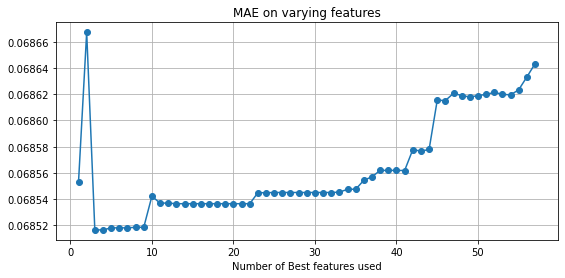

In [16]:
print ("Full score:", mae[-1])
print ("Best score:", min(mae))

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(range(1,len(best_features)+1), mae, 'o-', label="MAE")
ax.set_title("MAE on varying features")
ax.set_xlabel("Number of Best features used")
ax.grid();

In [17]:
lr = LinearRegression(fit_intercept=False, positive=True)
scaler.fit(X_train[best_features[:3]])
lr.fit(scaler.transform(X_train[best_features[:3]]), y_train)

print_measure(y_true=y_test, y_pred=lr.predict(scaler.transform(X_test[best_features[:3]])))

Mean absolute error: 0.07081
 Mean squared error: 0.03001
           R2 score: 0.00170


In [18]:
best_features[:3]

array(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet'],
      dtype='<U45')

This time we got the same error, but we needed just three features, getting a much more interpretable model. Inference here is really simple: size matters.

## Linear regression by county

Let's try now to analyze features impact by county. I'll assume that scaling data will always be the best choiche for the model performance.

In [4]:
import Zillow.data as zd
from Zillow.transform import ZillowTransformer, ZillowEncoder
from Zillow.types import County, Features as ft

import warnings
warnings.filterwarnings("ignore")
# Orange
o_train, o_validation, o_test = zd.get_preprocessed_data(County.ORANGE)

# Ventura
v_train, v_validation, v_test = zd.get_preprocessed_data(County.VENTURA)

# Los Angeles
la_train, la_validation, la_test = zd.get_preprocessed_data(County.LOS_ANGELES)

### Orange

I wrapped everything in a function

In [5]:
X_train_o, y_train_o = zd.split_x_y(o_train)
X_test_o, y_test_o = zd.split_x_y(o_validation)

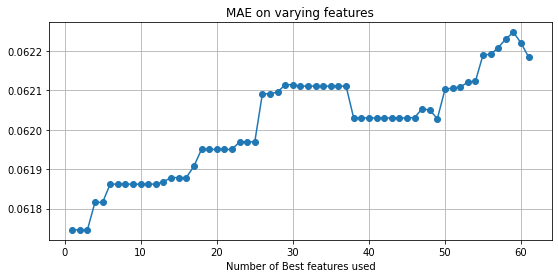

In [12]:
from Zillow.models import select_linear_regression_features

lm = LinearRegression(fit_intercept=False, positive=True)

best_params = select_linear_regression_features(X_train_o,
                                                y_train_o,
                                                lm_o,
                                                scale=True,
                                                plot=True)

In [8]:
best_params[0]

'bathroomcnt'

In [11]:
scaler.fit(X_train_o[best_params[:1]])
lm.fit(scaler.transform(X_train_o[best_params[:1]]), y_train_o)

print_measure(y_true=y_test_o, y_pred=lm.predict(scaler.transform(X_test_o[best_params[:1]])))

Mean absolute error: 0.06148
 Mean squared error: 0.02399
           R2 score: 0.00105


### Ventura

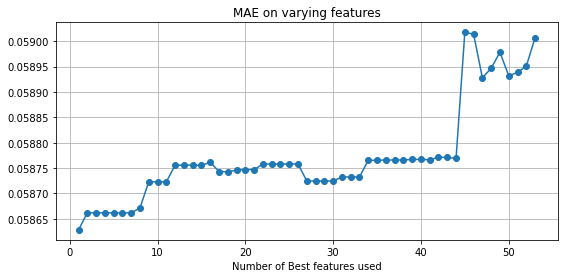

In [15]:
X_train_v, y_train_v = zd.split_x_y(v_train)
X_test_v, y_test_v = zd.split_x_y(v_validation)

best_features = select_linear_regression_features(X_train_v,
                                                y_train_v,
                                                lm,
                                                scale=True,
                                                plot=True)

In [16]:
scaler.fit(X_train_v[best_features[:1]])
lm.fit(scaler.transform(X_train_v[best_features[:1]]), y_train_v)

print_measure(y_true=y_test_v, y_pred=lm.predict(scaler.transform(X_test_v[best_features[:1]])))

Mean absolute error: 0.06092
 Mean squared error: 0.02936
           R2 score: 0.00228


In [17]:
best_features[:1]

array(['bathroomcnt'], dtype='<U36')

### Los Angeles

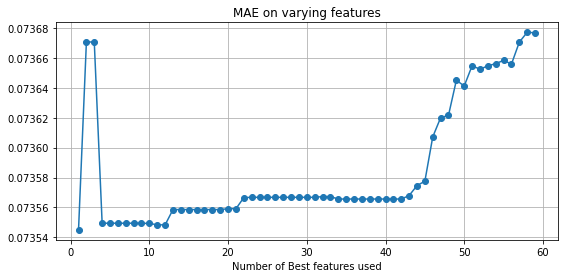

In [18]:
X_train_la, y_train_la = zd.split_x_y(la_train)
X_test_la, y_test_la = zd.split_x_y(la_test)

best_features = select_linear_regression_features(X_train_la,
                                                y_train_la,
                                                lm,
                                                scale=True,
                                                plot=True)

In [19]:
scaler.fit(X_train_la[best_features[:1]])
lm.fit(scaler.transform(X_train_la[best_features[:1]]), y_train_la)

print_measure(y_true=y_test_la, y_pred=lm.predict(scaler.transform(X_test_la[best_features[:1]])))

Mean absolute error: 0.07449
 Mean squared error: 0.02914
           R2 score: 0.00010


In [20]:
best_features[:1]

array(['bathroomcnt'], dtype='<U36')

## Summary

Here we plot a summary of models performance measured on mean absolute error over the entire dataset

In [28]:
from Zillow.metrics import measure_model

scores = []
tag = ['All', 'Orange', 'Ventura', 'LA']

train, validation, test = zd.get_preprocessed_data()
X_train, y_train = zd.split_x_y( pd.concat([train, validation], axis=0) )
X_test, y_test = zd.split_x_y(test)
    
best_features = select_linear_regression_features(X_train,
                                                  y_train,
                                                  lm,
                                                  scale=True)
    
scaler.fit(X_train[best_features[:3]])
lm.fit(scaler.transform(X_train[best_features[:3]]), y_train)
scores.append( measure_model(y_true=y_test,
                             y_pred=lm.predict(scaler.transform( X_test[best_features[:3]] )))[0] )

In [29]:
for county in [County.ORANGE, County.VENTURA, County.LOS_ANGELES]:
    train, validation, test = zd.get_preprocessed_data(county)
    X_train, y_train = zd.split_x_y( pd.concat([train, validation], axis=0) )
    X_test, y_test = zd.split_x_y(test)
    
    best_features = select_linear_regression_features(X_train,
                                                      y_train,
                                                      lm,
                                                      scale=True)
    
    scaler.fit(X_train[best_features[:1]])
    lm.fit(scaler.transform(X_train[best_features[:1]]), y_train)
    scores.append( measure_model(y_true=y_test,
                                 y_pred=lm.predict(scaler.transform( X_test[best_features[:1]] )))[0] )

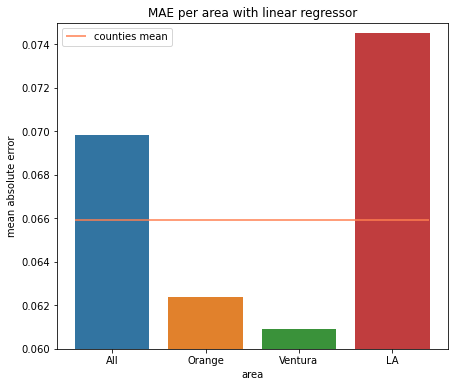

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(7, 6))
sns.barplot(data=pd.DataFrame({'score': scores, 'area': tag}), x='area', y='score', ax=ax)
ax.set_ylim(0.060,0.075);
ax.set_ylabel('mean absolute error')
ax.hlines(np.mean(scores[1:4]), xmin=-0.4, xmax=3.39, colors='coral', label='counties mean')
ax.legend()
ax.set_title('MAE per area with linear regressor');

# Albero di decisione

Studiamo ora la capacità predittiva di un albero di decisione

## Globalmente

In [46]:
import Zillow.data as zd

train, validation, test = zd.get_preprocessed_data()

X_train, y_train = zd.split_x_y(train)
X_validation, y_validation = zd.split_x_y(validation)

In questo caso si può cercare di trovare i parametri ottimi per l'albero di decisione, per risparmiare un po' di tempo di calcolo il tuning verrà effettuato sul $40\%$ del dataset di train

In [45]:
from sklearn.model_selection import train_test_split

X_small, _, y_small, _ = train_test_split(X_train, y_train, train_size=0.4, random_state=42)

len(X_small), len(y_small)

(42972, 42972)

Even if we are evaluating the model with *mean absolute error* here we do cross validation on *mean squared error* criterion because it takes less time (more information about the sklearn implementation complexity can be found [here](https://github.com/scikit-learn/scikit-learn/issues/9626))

In [35]:
%%time
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

lr = DecisionTreeRegressor()

params = {
    'criterion': ['squared_error'],
    'splitter': ['random', 'best'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [x for x in range(2, 101)],
    'max_features': ['sqrt', 1.0]
}

gscv = GridSearchCV(estimator=lr,
                    return_train_score=True,
                    scoring='neg_mean_absolute_error',
                    param_grid=params,
                    cv=4,
                    verbose=1,
                    n_jobs=-1,
                   )

gscv.fit(X_train, y_train)

gscv.best_params_

Fitting 4 folds for each of 4752 candidates, totalling 19008 fits
CPU times: user 33.5 s, sys: 7.35 s, total: 40.9 s
Wall time: 21min 20s


{'criterion': 'squared_error',
 'max_features': 1.0,
 'max_leaf_nodes': 9,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'splitter': 'random'}

Ovviamente il modello performa meglio con un numero basso di foglie: all'aumentare del numero di foglie il modello dovrebbe specializzarsi sempre più, andando in overfitting

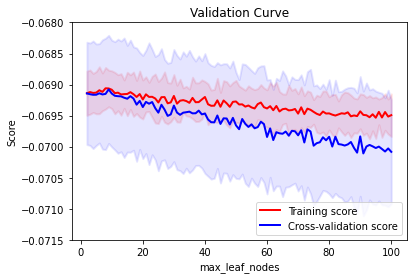

In [46]:
import Zillow.visualization as zv

zv.plot_grid_search_validation_curve(gscv, 'max_leaf_nodes', ylim=(-.0715,-.068))

Verifichiamo la performance allenando il modello sull'intero dataset

In [48]:
from Zillow.metrics import measure_model, print_measure

errors = []

regressor = DecisionTreeRegressor(splitter='random',
                           min_samples_split=2,
                           min_samples_leaf=10,
                           max_leaf_nodes=9,
                           max_features=1.,
                           random_state=42)

regressor.fit(X_train, y_train)
errors.append(measure_model(y_true=y_validation, y_pred=regressor.predict(X_validation)))
print_measure(y_true=y_validation, y_pred=regressor.predict(X_validation))

Mean absolute error: 0.07103
 Mean squared error: 0.02995
           R2 score: 0.00344


Here there isn't much to feature select since we used a tree with 9 leaf, so it doesn't

In [49]:
regressor.feature_importances_

array([0.38324699, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.17389785, 0.        , 0.26951699,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07510948, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.09822868, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

CPU times: user 64 ms, sys: 4.02 ms, total: 68 ms
Wall time: 64.1 ms


[Text(0.6923076923076923, 0.9375, 'bathroomcnt <= 3.5709377\nsquared_error = 0.0271391\nsamples = 134287\nvalue = 0.0135875'),
 Text(0.5384615384615384, 0.8125, 'structuretaxvaluedollarcnt <= 2121076.6391448\nsquared_error = 0.0254296\nsamples = 124095\nvalue = 0.0122914'),
 Text(0.46153846153846156, 0.6875, 'structuretaxvaluedollarcnt_was_nan <= 0.2024705\nsquared_error = 0.0252001\nsamples = 124077\nvalue = 0.0122275'),
 Text(0.38461538461538464, 0.5625, 'taxdelinquencyflag <= 0.8063771\nsquared_error = 0.0250518\nsamples = 123706\nvalue = 0.0123871'),
 Text(0.3076923076923077, 0.4375, 'calculatedfinishedsquarefeet <= 2648.6824657\nsquared_error = 0.0245417\nsamples = 120280\nvalue = 0.0119145'),
 Text(0.23076923076923078, 0.3125, 'calculatedfinishedsquarefeet <= 407.1958592\nsquared_error = 0.0235418\nsamples = 111329\nvalue = 0.010983'),
 Text(0.15384615384615385, 0.1875, 'x1_Thursday <= 0.952642\nsquared_error = 0.3116536\nsamples = 84\nvalue = 0.1649495'),
 Text(0.076923076923076

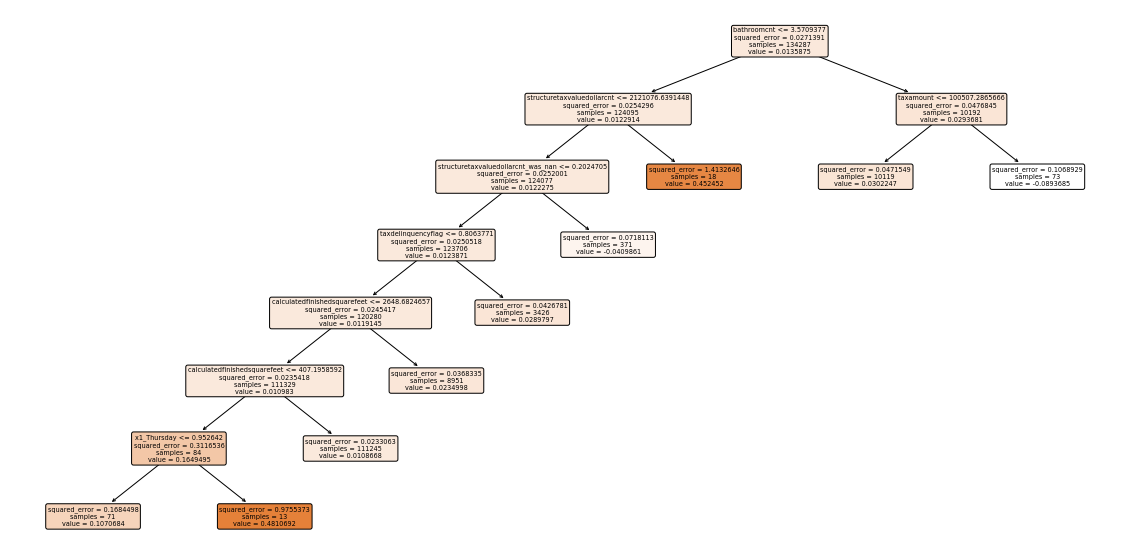

In [9]:
%%time
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(20,10))
plot_tree(regressor, ax=ax,
          precision=7,
          feature_names=X_train.columns.to_list(),
          filled=True, rounded=True);

## Albero di decisione per contea

Si assume che l'ottimo trovato con il GridSearch per il modello generico sia lo stesso per le tre county (che in realtà hanno feature diverse, sarebbe quindi utile rieseguire una ricerca dei parametri ottimali)

In [10]:
import Zillow.data as zd
from Zillow.transform import ZillowTransformer, ZillowEncoder
from Zillow.types import County, Features as ft

import warnings
warnings.filterwarnings("ignore")
# Orange
o_train, o_validation, o_test = zd.get_preprocessed_data(County.ORANGE)

# Ventura
v_train, v_validation, v_test = zd.get_preprocessed_data(County.VENTURA)

# Los Angeles
la_train, la_validation, la_test = zd.get_preprocessed_data(County.LOS_ANGELES)

In [12]:
train = pd.concat([o_train, o_validation], axis=0, ignore_index=True)
X_train_o, y_train_o = zd.split_x_y(train)
X_test_o, y_test_o = zd.split_x_y(o_test)

In [13]:
from sklearn.tree import DecisionTreeRegressor
from Zillow.metrics import measure_model

regressor = DecisionTreeRegressor(splitter='random',
                           min_samples_split=2,
                           min_samples_leaf=10,
                           max_leaf_nodes=9,
                           max_features=1.,
                           random_state=42)

train = pd.concat([o_train, o_validation], axis=0, ignore_index=True)
X_train_o, y_train_o = zd.split_x_y(train)

regressor.fit( X_train_o, y_train_o)
print('Orange')
errors.append(measure_model(y_true=y_test_o, y_pred=regressor.predict(X_test_o)))
print_measure(y_true=y_test_o, y_pred=regressor.predict(X_test_o))

Orange
Mean absolute error: 0.06262
 Mean squared error: 0.02425
           R2 score: -0.00756


In [14]:
# Ventura
train = pd.concat([v_train, v_validation], axis=0, ignore_index=True)
X_train_v, y_train_v = zd.split_x_y(train)
X_test_v, y_test_v = zd.split_x_y(v_test)

regressor.fit( X_train_v, y_train_v)
print('Ventura')
errors.append(measure_model(y_true=y_test_v, y_pred=regressor.predict(X_test_v)))
print_measure(y_true=y_test_v, y_pred=regressor.predict(X_test_v))

Ventura
Mean absolute error: 0.06101
 Mean squared error: 0.02852
           R2 score: 0.00333


In [15]:
# LA
train = pd.concat([la_train, la_validation], axis=0, ignore_index=True)
X_train_la, y_train_la = zd.split_x_y(train)
X_test_la, y_test_la = zd.split_x_y(la_test)

regressor.fit( X_train_la, y_train_la)
print('LA')
errors.append(measure_model(y_true=y_test_la, y_pred=regressor.predict(X_test_la)))
print_measure(y_true=y_test_la, y_pred=regressor.predict(X_test_la))

LA
Mean absolute error: 0.07475
 Mean squared error: 0.02904
           R2 score: 0.00361


In [17]:
import numpy as np
np.mean([e[0] for e in errors])

0.06709834316780826

Text(0.5, 1.0, 'MAE per area with dicision tree')

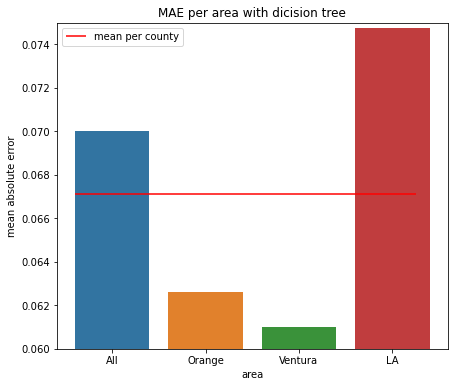

In [35]:
fig, ax = plt.subplots(figsize=(7, 6))
data = pd.DataFrame({'score': [0.07002, 0.06262, 0.06101, 0.07475], 'area': ['All', 'Orange', 'Ventura', 'LA']})
sns.barplot(data=data, x='area', y='score', ax=ax)
ax.set_ylim(0.060,0.075);
ax.set_ylabel('mean absolute error')
ax.hlines(0.06709834316780826, xmin=-0.4, xmax=3.25, colors='red', label='mean per county');
ax.legend()
ax.set_title('MAE per area with dicision tree')